In [2]:
!git clone https://github.com/05rs/Face-Recogination.git
import sys
sys.path.append('./Face-Recogination/FaceNet')
# !pip install -r '/content/Face-Recogination/FaceNet/requirements.txt'
import align
import data
import utils
import model
import matplotlib.pyplot as plt
import numpy as np

Cloning into 'Face-Recogination'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 479 (delta 23), reused 46 (delta 6), pack-reused 407
Receiving objects: 100% (479/479), 152.04 MiB | 22.87 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (626/626), done.


In [7]:
import numpy as np

In [3]:
import pickle
pkl_file = open('/content/Face-Recogination/FaceNet/data/data.pkl', 'rb')
data = pickle.load(pkl_file)
# pckl files...
seq = data['seq']             # Label key
itr = data['itr']             # iterator
embedded = data['embedded']   # 100 dims embedded vec
label = data['label']         # encoded label
images = data['images']       # raw image
decode_label = { seq[k]:k for k in seq.keys()}


In [5]:
from model import create_model
nn4_small2 = create_model()
nn4_small2.load_weights('/content/Face-Recogination/FaceNet/weights/fine_tuned_nn4_small.h5')

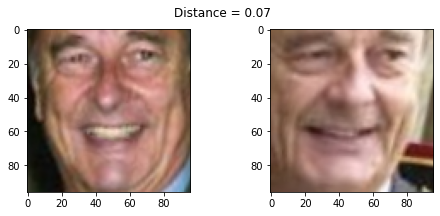

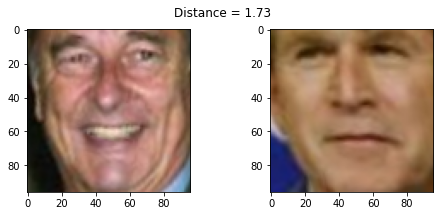

In [9]:
embedded = np.array(nn4_small2.predict(images))
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(images[idx1])
    plt.subplot(122)
    plt.imshow(images[idx2]);    

show_pair(77, 71)
show_pair(77, 40)

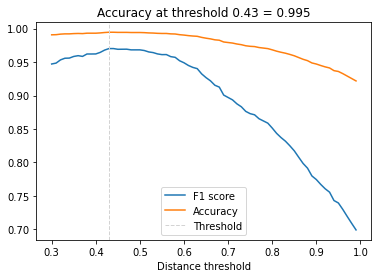

In [10]:
from sklearn.metrics import f1_score, accuracy_score

embedded = np.array(nn4_small2.predict(images))

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(images)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if label[i] == label[j]else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

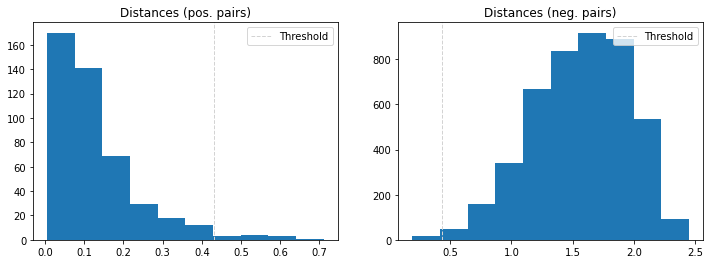

In [11]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

targets = label.reshape(100)

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(images.shape[0]) % 2 != 0
test_idx = np.arange(images.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()
gnb = GaussianNB()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))
acc_gnb = accuracy_score(y_test, gnb.fit(X_train, y_train).predict(X_test))


print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}, gnb accuracy = {acc_gnb}')

KNN accuracy = 0.98, SVM accuracy = 0.98, gnb accuracy = 1.0


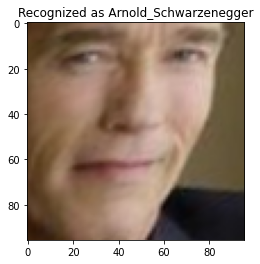

In [24]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 12

example_image = images[example_idx]
example_prediction = gnb.predict([embedded[example_idx]])
example_identity = decode_label[encoder.inverse_transform(example_prediction)[0]]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

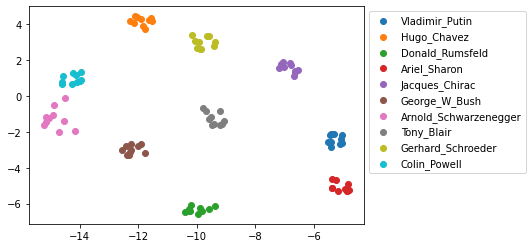

In [14]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=decode_label[t])   

plt.legend(bbox_to_anchor=(1, 1));

